In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

# Household power consumption dataset

In [2]:
df = pd.read_csv('/content/household_power_consumption.csv') # read in the Household power consmption dataset

In [3]:
# Combine 'Date' and 'Time' columns into a single 'Datetime' column and cast each instance to a datetime type

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('Datetime') # set index to the datetime column for household power consumption dataset
df = df.drop(columns=['Date', 'Time'])
df = df.replace('?', np.nan)

# Convert relevant columns to numeric type
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column is of object type
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass  # Skip columns that cannot be converted

df['Global_active_power'].describe() # generate descriptive statistics for the dataset


<ipython-input-3-e6c19b7f4b80>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Global_active_power
count,114215.000000
mean,1.419375
std,1.300670
min,0.198000
25%,0.326000
50%,1.288000
75%,2.106000
max,10.670000


In [4]:
percentage = pd.isnull(df).sum() / len(df) * 100
print(percentage)
df = df.dropna()

Global_active_power      0.003502
Global_reactive_power    0.003502
Voltage                  0.003502
Global_intensity         0.004378
Sub_metering_1           0.004378
Sub_metering_2           0.004378
Sub_metering_3           0.004378
dtype: float64


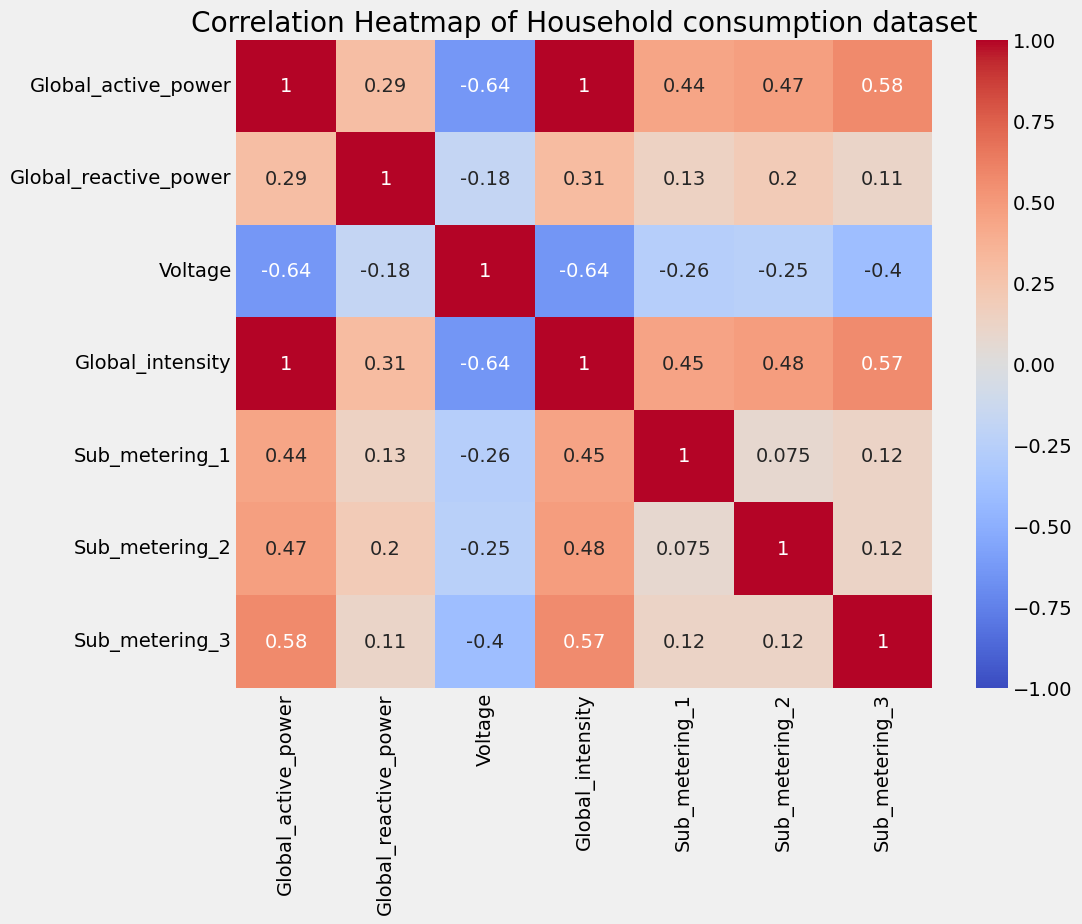

In [5]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Household consumption dataset')
plt.show()

In [6]:
# Drop all columns apart from Global_active_power
df = df.drop(columns=['Global_reactive_power', 'Voltage', 	'Global_intensity', 	'Sub_metering_1', 	'Sub_metering_2', 	'Sub_metering_3'])


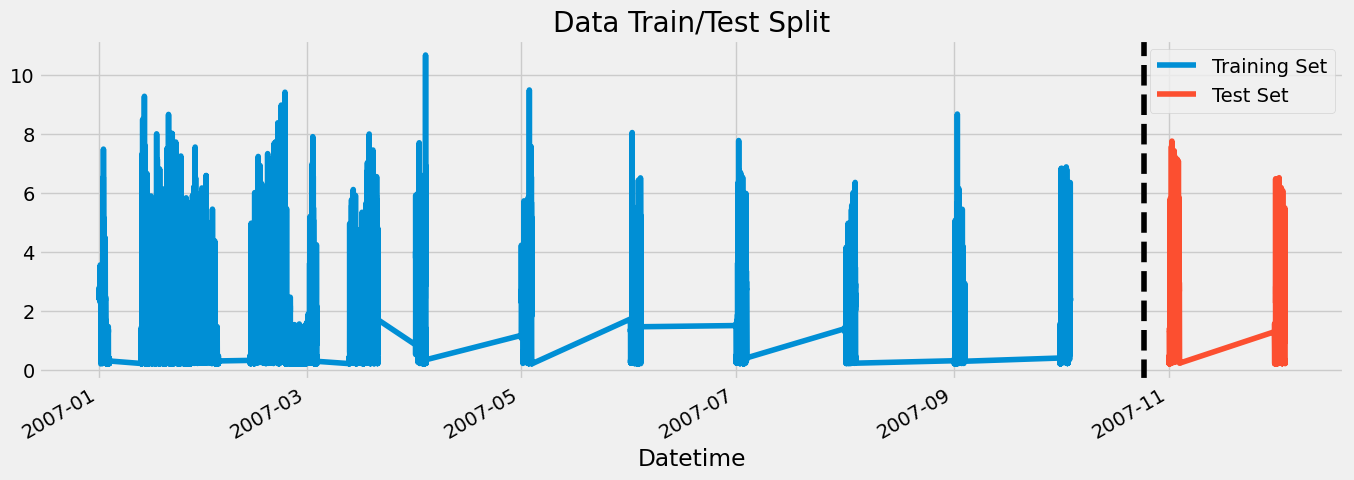

In [7]:
# Train-Test split on household dataset
train = df.loc[df.index < '10-24-2007']
test = df.loc[df.index >= '10-25-2007']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('10-25-2007', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
# Decomposition of time series data by seasonality
def create_features(df):
    """
    Create time series features based on time series index using the pandas library.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

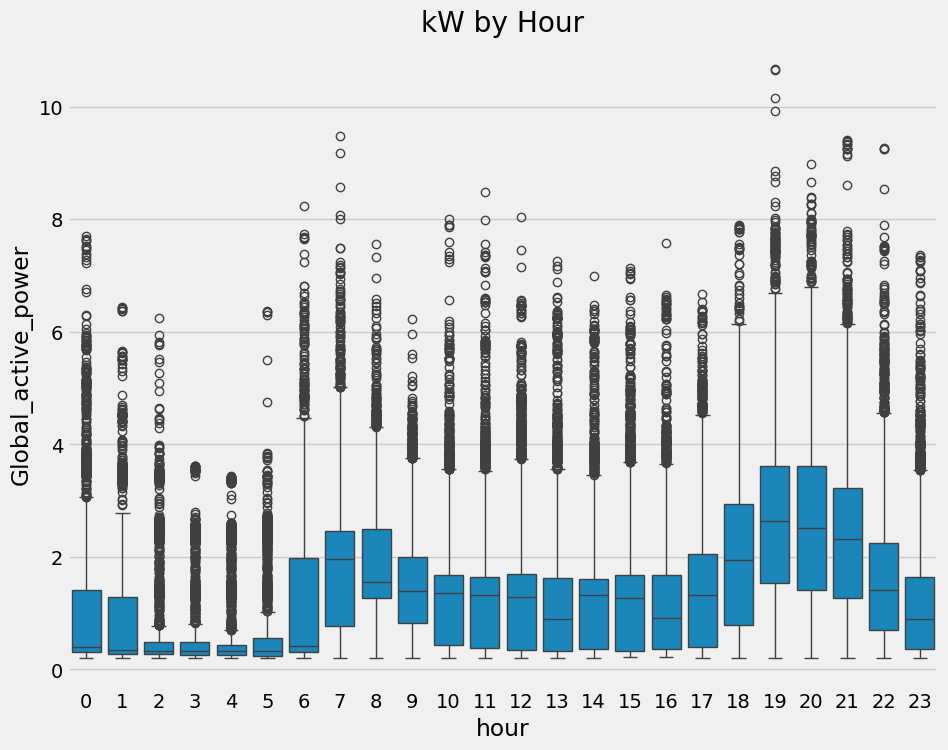

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Global_active_power')
ax.set_title('kW by Hour')
plt.show()

<ipython-input-12-1b43901d0494>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Global_active_power', palette='Blues')


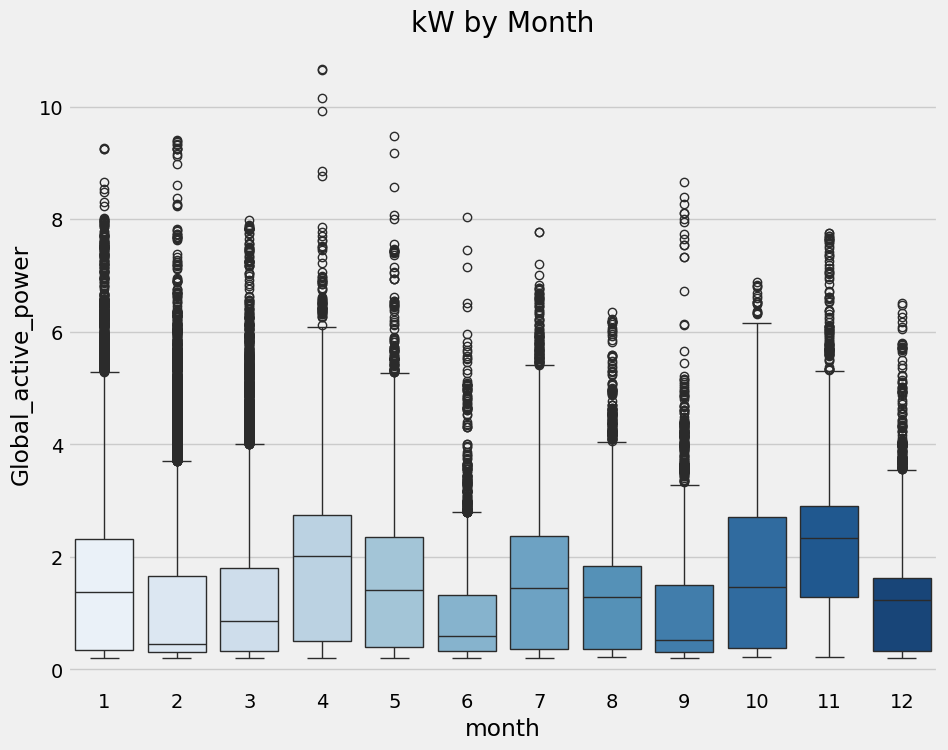

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Global_active_power', palette='Blues')
ax.set_title('kW by Month')
plt.show()

In [22]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#FEATURES = ['hour', 'dayofyear']
TARGET = 'Global_active_power'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
# Decision Tree model

param_grid_dt = {
            "splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":["log2","sqrt"],
           "max_leaf_nodes":[2, 3, 5,10,20]  # Changed min value to 2
            }

dt = DecisionTreeRegressor(random_state=32)

# Define the cross validation strategy

kfold = KFold(n_splits=5, shuffle=True, random_state=32)

random_search_dt = RandomizedSearchCV(estimator=dt,
                                   param_distributions=param_grid_dt,
                                   n_iter=50,
                                   cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1
                                   )

# Handle missing values in y_train before fitting

random_search_dt.fit(X_train, y_train)  # Fit with cleaned data

print("Best parameters found: ", random_search_dt.best_params_)
print("Best cross-validation score: ", random_search_dt.best_score_)

best_model = random_search_dt.best_estimator_

# Predictions on training set
y_train_pred_dt = best_model.predict(X_train)

# Predictions on test set
y_test_pred_dt = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_dt = mean_squared_error(y_train, y_train_pred_dt)
mse_test_dt = mean_squared_error(y_test, y_test_pred_dt)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_dt = np.sqrt(mse_train_dt)
rmse_test_dt = np.sqrt(mse_test_dt)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_dt))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_dt))

# Print results
print(f"Mean Squared Error of training set: {mse_train_dt}")
print(f"Root Mean Squared Error of training set: {rmse_train_dt}")

print(f"Mean Squared Error of test set: {mse_test_dt}")
print(f"Root Mean Squared Error of test set: {rmse_test_dt}")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%")

Best parameters found:  {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 7, 'max_leaf_nodes': 10, 'max_features': 'log2', 'max_depth': 12}
Best cross-validation score:  -1.5426649359544373
Mean Squared Error of training set: 1.5422072732229561
Root Mean Squared Error of training set: 1.2418563818827668
Mean Squared Error of test set: 1.6801275055748293
Root Mean Squared Error of test set: 1.2961973250916812
Mean Absolute Error (MAE): 1.00
Total Absolute Error (TAE) Percentage: 59.43%


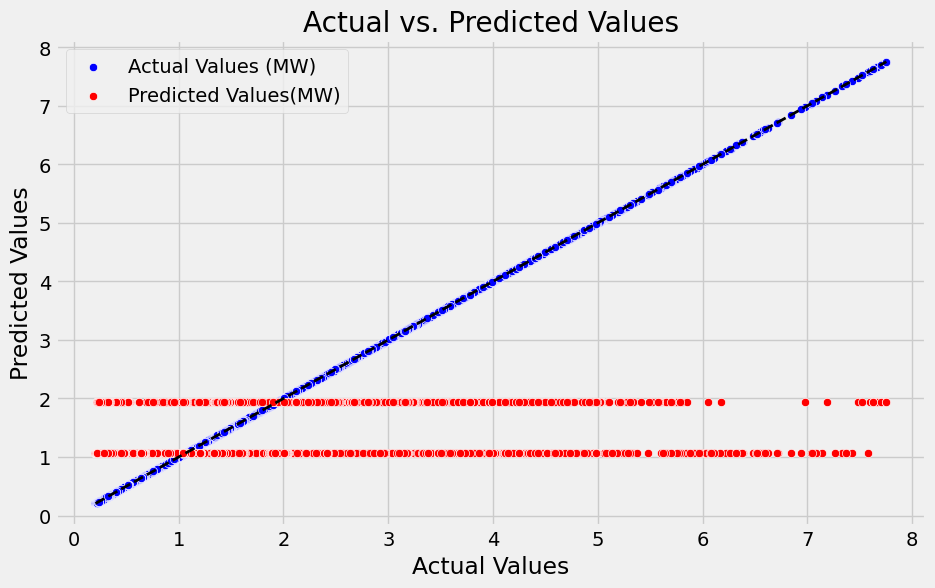

In [24]:
# Scatterplot of actual vs. predicted values
plt.figure(figsize=(10, 6))

# Plotting actual values
sns.scatterplot(x=y_test, y=y_test, label='Actual Values (MW)', color='blue')

# Plotting predicted values
sns.scatterplot(x=y_test, y=y_test_pred_dt, label='Predicted Values(MW)', color='red')

# Adding a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [17]:
# Random Forest model with all features

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(n_estimators=205,
                           min_samples_split=3,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           random_state=32)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid_rf,
                                   n_iter=50, cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1,
                                    error_score=True,
                                    verbose=10
                                   )
random_search_rf.fit(X_train, y_train)

print("Best parameters found: ", random_search_rf.best_params_)
print("Best cross-validation score: ", random_search_rf.best_score_)

best_model = random_search_rf.best_estimator_

# Predictions on training set
y_train_pred_rf = best_model.predict(X_train)

# Predictions on test set
y_test_pred_rf = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_rf))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_rf))

# Print results
print(f"Mean Squared Error of training set: {mse_train_rf}")
print(f"Root Mean Squared Error of training set: {rmse_train_rf}")


print(f"Mean Squared Error of test set: {mse_test_rf}")
print(f"Root Mean Squared Error of test set: {rmse_test_rf}")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score:  -0.4248046241772615
Mean Squared Error of training set: 0.40995357507484526
Root Mean Squared Error of training set: 0.6402761709409818
Mean Squared Error of test set: 1.951539464104362
Root Mean Squared Error of test set: 1.3969751121993412
Mean Absolute Error (MAE): 1.07
Total Absolute Error (TAE) Percentage: 63.23%


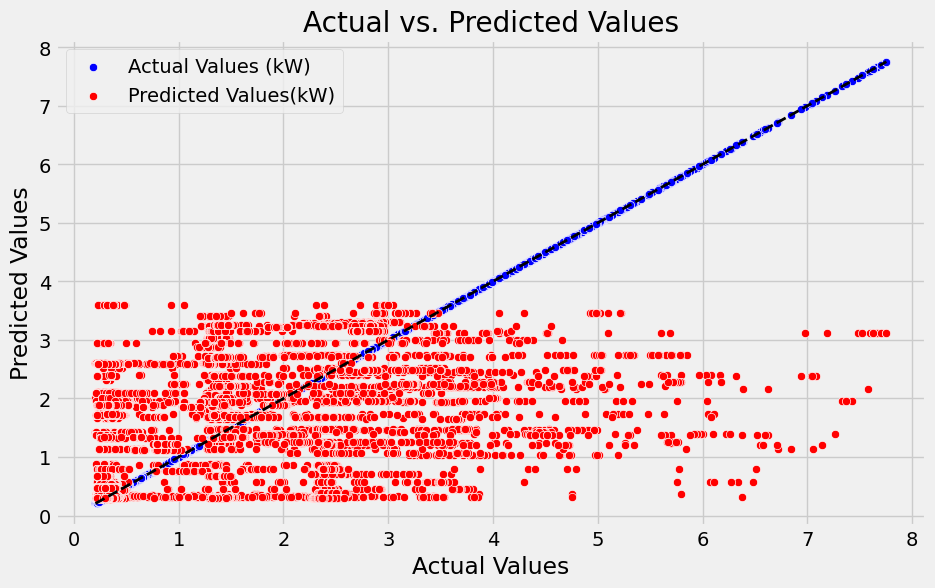

In [26]:
# Scatterplot of actual vs. predicted values
plt.figure(figsize=(10, 6))

# Plotting actual values
sns.scatterplot(x=y_test, y=y_test, label='Actual Values (kW)', color='blue')

# Plotting predicted values
sns.scatterplot(x=y_test, y=y_test_pred_rf, label='Predicted Values(kW)', color='red')

# Adding a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

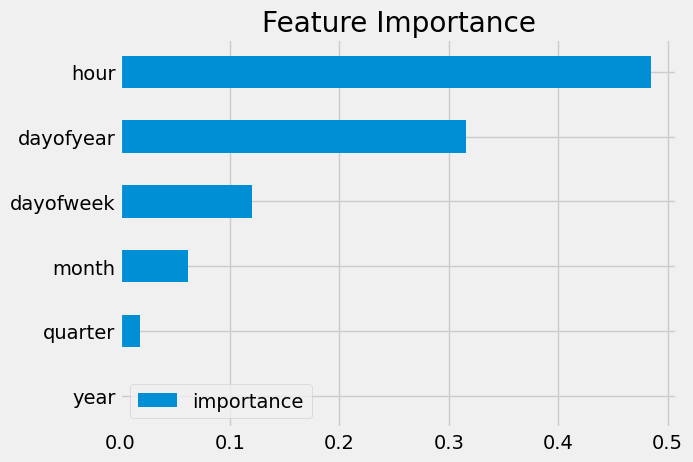

In [18]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [19]:
# Random Forest model with 2 top features

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(n_estimators=205,
                           min_samples_split=3,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           random_state=32)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid_rf,
                                   n_iter=50, cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1,
                                    error_score=True,
                                    verbose=10
                                   )
random_search_rf.fit(X_train, y_train)

print("Best parameters found: ", random_search_rf.best_params_)
print("Best cross-validation score: ", random_search_rf.best_score_)

best_model = random_search_rf.best_estimator_

# Predictions on training set
y_train_pred_rf = best_model.predict(X_train)

# Predictions on test set
y_test_pred_rf = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_rf))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_rf))

# Print results
print(f"Mean Squared Error of training set: {mse_train_rf}")
print(f"Root Mean Squared Error of training set: {rmse_train_rf}")


print(f"Mean Squared Error of test set: {mse_test_rf}")
print(f"Root Mean Squared Error of test set: {rmse_test_rf}")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score:  -0.4248046241772615
Mean Squared Error of training set: 0.40995357507484526
Root Mean Squared Error of training set: 0.6402761709409818
Mean Squared Error of test set: 1.951539464104362
Root Mean Squared Error of test set: 1.3969751121993412
Mean Absolute Error (MAE): 1.07
Total Absolute Error (TAE) Percentage: 63.23%
